# EDA for California fires perimeter data

Modules: N/A <br>
Author: Joy McGillin <br>
Email: jmcgillin@berkeley.edu <br>
Date created: February 12, 2023 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

Layer 0 - accidental wildfires
Layer 1 - prescribed fires 
Layer 2 - non-prescribed fire fuel reduction projects

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [4]:
# standard
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates


# geospatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)

### Step 2: Read cleaned data

```read data```

In [5]:
# read in the cleaned data and set index
data = pd.read_csv('fires_clean.csv', index_col='Index')

In [6]:
len(data)

16212

In [9]:
data.columns

Index(['FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'GIS_ACRES',
       'Shape_Length', 'Shape_Area', 'geometry', 'fire_centroid', 'DURATION',
       'FIRE_AREA_KM2'],
      dtype='object')

In [5]:
data.describe()

,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,FIRE_AREA_KM2
count,16203.000000,1.621200e+04,1.621200e+04,1.621200e+04,16212.000000
mean,8.620564,2.089187e+03,9.536973e+03,8.454641e+06,8.454642
std,5.332803,1.644505e+04,3.135563e+04,6.655077e+07,66.550766
min,1.000000,1.356887e-03,8.838431e+00,5.491126e+00,0.000005
25%,2.000000,2.016485e+01,1.403269e+03,8.160424e+04,0.081604
50%,9.000000,1.144252e+02,3.502184e+03,4.630622e+05,0.463062
75%,14.000000,5.787298e+02,8.165607e+03,2.342037e+06,2.342036
max,19.000000,1.032700e+06,1.533820e+06,4.179187e+09,4179.187059


In [6]:
print(data.isnull().sum())

FIRE_NAME          98
ALARM_DATE          0
CONT_DATE        7247
CAUSE               9
GIS_ACRES           0
Shape_Length        0
Shape_Area          0
geometry            0
fire_centroid       0
DURATION         7247
FIRE_AREA_KM2       0
dtype: int64


In [7]:
data['GIS_ACRES'] = data['GIS_ACRES'].astype(int)

In [8]:
data[data['GIS_ACRES'] < 10000].count()

FIRE_NAME        15551
ALARM_DATE       15649
CONT_DATE         8612
CAUSE            15641
GIS_ACRES        15649
Shape_Length     15649
Shape_Area       15649
geometry         15649
fire_centroid    15649
DURATION          8612
FIRE_AREA_KM2    15649
dtype: int64

In [9]:
data[data['GIS_ACRES'] > 10000].count()

FIRE_NAME        563
ALARM_DATE       563
CONT_DATE        353
CAUSE            562
GIS_ACRES        563
Shape_Length     563
Shape_Area       563
geometry         563
fire_centroid    563
DURATION         353
FIRE_AREA_KM2    563
dtype: int64

In [10]:
15649+563

16212

In [11]:
15649/16212

0.9652726375524303

<Axes: ylabel='Density'>

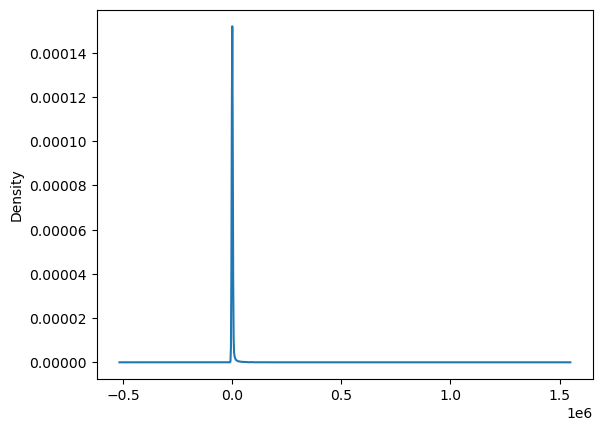

In [12]:
data['GIS_ACRES'].plot.kde()

<Axes: ylabel='Frequency'>

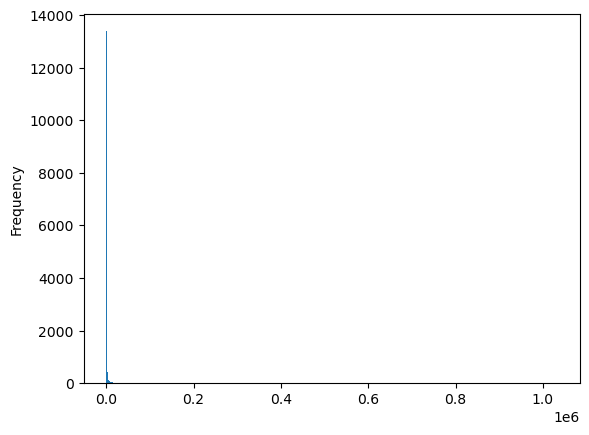

In [13]:
data['GIS_ACRES'].plot.hist(bins=1000)

Over 96% of the wildfires (in the cleaned dataset) burned less than 10,000 acres. 4% of ~563 were greater than 10,000 acres. The largest was the August Complex Fire in 2020 in which 1 million acres burned.

(0.0, 1000.0)

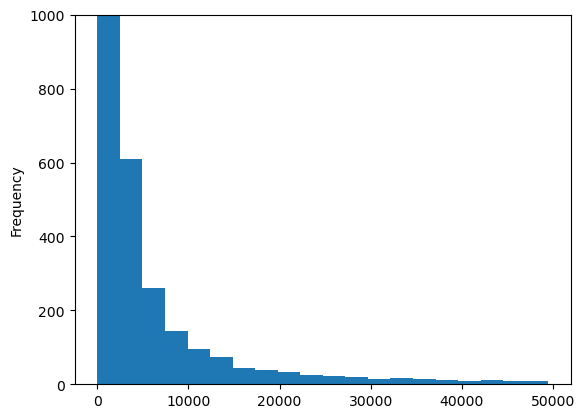

In [14]:
# plot fires less than 50,000 acres and cut off y-axis at 1,000
bulkacres = data[data.GIS_ACRES < 50000]
bulkacres['GIS_ACRES'].plot.hist(bins=20)
# plt.xlim(0,1000)
plt.ylim(0,1000)

<Axes: >

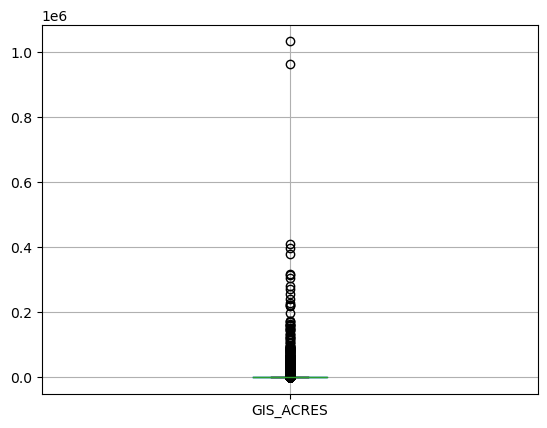

In [15]:
data.boxplot(column='GIS_ACRES')

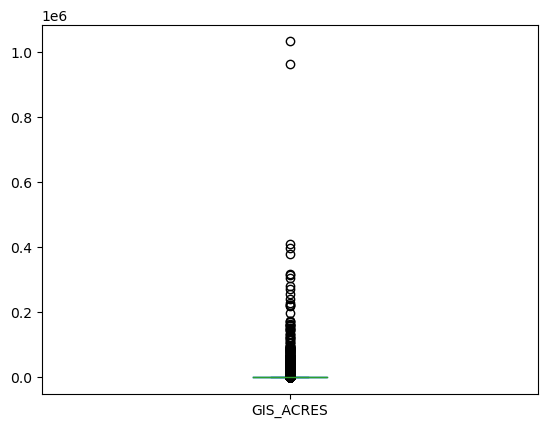

In [16]:
data['GIS_ACRES'].plot(kind='box');

In [17]:
outliers = data[data.GIS_ACRES > 10000]
outliers.sort_values(by=['GIS_ACRES'], ascending=False)

,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,geometry,fire_centroid,DURATION,FIRE_AREA_KM2
Index,,,,,,,,,,,
293,AUGUST COMPLEX,2020-08-16,2020-11-11,1.0,1032699,1.298407e+06,4.179187e+09,MULTIPOLYGON (((-122.7090616521175 39.37204016...,POINT (-122.9964731720786 39.93085451936486),87 days,4179.187059
21674,DIXIE,2021-07-14,2021-10-25,11.0,963405,1.533820e+06,3.898763e+09,MULTIPOLYGON (((-121.0890189068281 40.32210161...,POINT (-121.0466714946169 40.21009648505633),103 days,3898.763521
20799,RANCH,2018-07-27,2018-09-19,9.0,410202,3.482277e+05,1.660030e+09,MULTIPOLYGON (((-122.7106315635918 39.04618378...,POINT (-122.7679707721423 39.28698639985332),54 days,1660.030464
174,SCU COMPLEX,2020-08-16,2020-09-11,1.0,396824,5.033547e+05,1.605892e+09,MULTIPOLYGON (((-121.8648589465547 37.51711837...,POINT (-121.4470483655014 37.35125711385501),26 days,1605.891596
241,CREEK,2020-09-04,2020-12-24,14.0,379842,8.180878e+05,1.537168e+09,MULTIPOLYGON (((-119.1813091887084 37.09619618...,POINT (-119.2763146671175 37.33267100441917),111 days,1537.167716
...,...,...,...,...,...,...,...,...,...,...,...
6345,TENAJA,1975-09-22,1975-09-26,2.0,10161,3.417882e+04,4.112256e+07,MULTIPOLYGON (((-117.3311430227495 33.49988206...,POINT (-117.3444274948232 33.46506551291561),4 days,41.122562
8415,RUBY FIRE,1987-09-20,1987-09-20,9.0,10092,4.172441e+04,4.084457e+07,MULTIPOLYGON (((-118.5738982425678 34.62737141...,POINT (-118.5554567854358 34.59410153280944),0 days,40.844575
14313,BEE #2,1996-06-29,1996-07-06,9.0,10046,3.783034e+04,4.065623e+07,MULTIPOLYGON (((-116.8325673057113 33.78216809...,POINT (-116.8153864207838 33.75744665731662),7 days,40.656228


Only 563 fires greater than burned over 10,000 acres

The "August Complex Fire" burned in Northern California. It was 38 separate fires started by lightning strikes. https://en.wikipedia.org/wiki/August_Complex_fire

In [18]:
data['DURATION']=pd.to_timedelta(data['DURATION'])

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16212 entries, 0 to 21687
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   FIRE_NAME      16114 non-null  object         
 1   ALARM_DATE     16212 non-null  object         
 2   CONT_DATE      8965 non-null   object         
 3   CAUSE          16203 non-null  float64        
 4   GIS_ACRES      16212 non-null  int32          
 5   Shape_Length   16212 non-null  float64        
 6   Shape_Area     16212 non-null  float64        
 7   geometry       16212 non-null  object         
 8   fire_centroid  16212 non-null  object         
 9   DURATION       8965 non-null   timedelta64[ns]
 10  FIRE_AREA_KM2  16212 non-null  float64        
dtypes: float64(4), int32(1), object(5), timedelta64[ns](1)
memory usage: 1.4+ MB


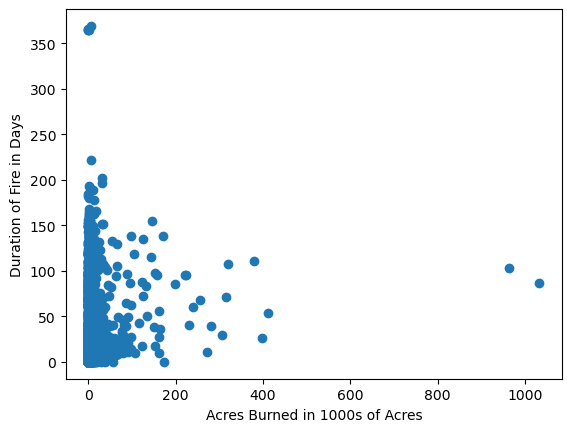

In [20]:
# timedeltas for DURATION are in nanoseconds; divide to convert to days
y = data['DURATION'].transform(lambda x: x.days)
fig, ax = plt.subplots()
ax.scatter(x=data["GIS_ACRES"],y=y)
ax.set_ylabel("Duration of Fire in Days")
ax.set_xlabel("Acres Burned in 1000s of Acres")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/1000)))

In [21]:
# drop fires with no CONT_DATE
data_small = data[~(data.CONT_DATE.isna())]

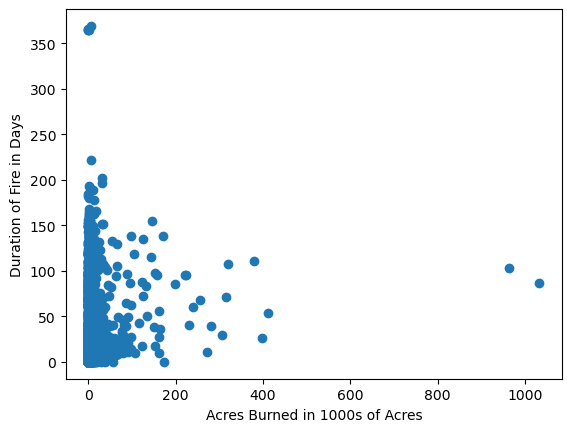

In [22]:
y = data_small['DURATION'].transform(lambda x: x.days)
fig, ax = plt.subplots()
ax.scatter(x=data_small["GIS_ACRES"],y=y)
ax.set_ylabel("Duration of Fire in Days")
ax.set_xlabel("Acres Burned in 1000s of Acres")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x/1000)))

In [23]:
print(len(data))
print(len(data_small))

16212
8965


In [24]:
# data.drop(21451, inplace=True)
duration_outlier_index = data.DURATION.idxmax()
data.loc[duration_outlier_index]

FIRE_NAME                                                 SOUTHERN
ALARM_DATE                                              2021-05-02
CONT_DATE                                               2022-05-06
CAUSE                                                          2.0
GIS_ACRES                                                     5365
Shape_Length                                          46656.289969
Shape_Area                                         21715034.722717
geometry         MULTIPOLYGON (((-116.44421817649 32.9676144702...
fire_centroid         POINT (-116.4661834909014 32.98161109590223)
DURATION                                         369 days 00:00:00
FIRE_AREA_KM2                                            21.715034
Name: 21426, dtype: object